In [1]:
! pip install -q kaggle

In [2]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! kaggle datasets download -d jangedoo/utkface-new

 96% 317M/331M [00:02<00:00, 161MB/s]
100% 331M/331M [00:02<00:00, 134MB/s]


In [6]:
! unzip -qq utkface-new.zip

In [9]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [10]:
width = height = 224

In [12]:
images = []
ages = []

for image_name in os.listdir('crop_part1'):
  parts = image_name.split('_')
  age = int(parts[0])
  ages.append(age)

  image = cv2.imread('crop_part1/' + image_name)
  image = cv2.resize(image, (width, height))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  images.append(image)

In [15]:
images = pd.Series(images, name='Images')
ages = pd.Series(ages, name='Ages')

df = pd.concat((images, ages), axis=1)
df.head()

,Images,Ages
0,"[[[154, 154, 128], [161, 161, 136], [167, 167,...",2
1,"[[[90, 62, 40], [78, 50, 28], [70, 42, 20], [6...",5
2,"[[[52, 37, 16], [52, 37, 16], [53, 38, 17], [5...",57
3,"[[[99, 127, 149], [89, 117, 139], [75, 100, 12...",29
4,"[[[27, 38, 30], [29, 40, 31], [33, 41, 33], [3...",52


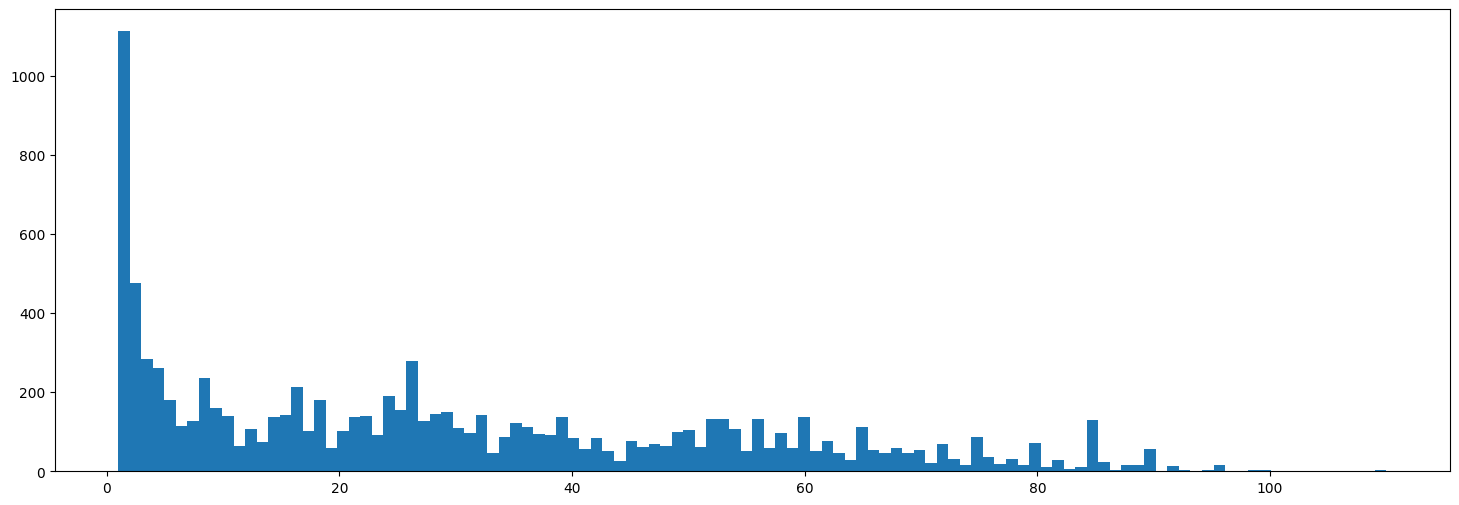

In [17]:
plt.figure(figsize=(18, 6))
plt.hist(df['Ages'], bins=df['Ages'].max())
plt.show()

In [18]:
under_4 = df[df['Ages'] <= 4]
up_4 = df[df['Ages'] > 4]

under_4 = under_4.sample(frac=0.3)

df = pd.concat([under_4, up_4], axis=0)

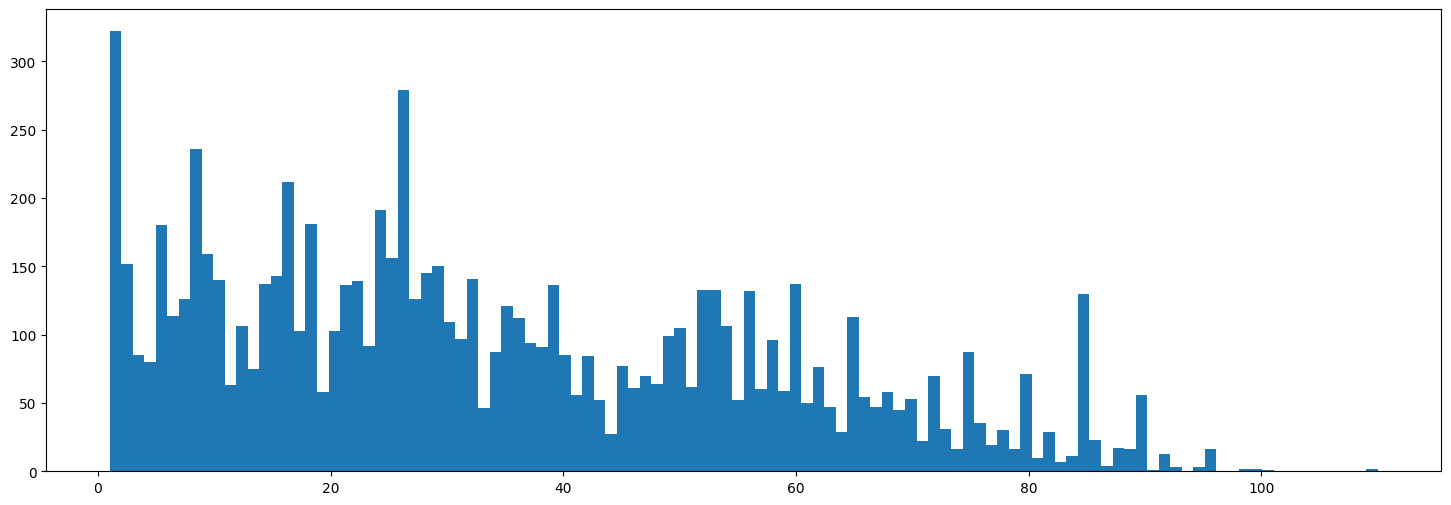

In [19]:
plt.figure(figsize=(18, 6))
plt.hist(df['Ages'], bins=df['Ages'].max())
plt.show()

In [20]:
df = df[df['Ages'] < 80]

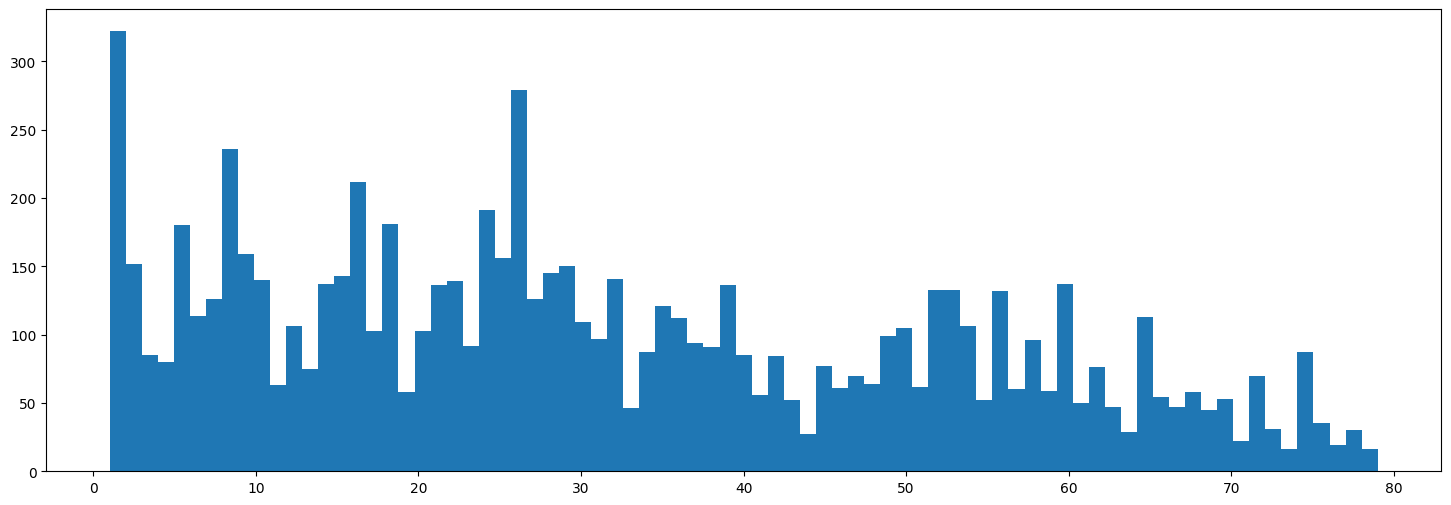

In [21]:
plt.figure(figsize=(18, 6))
plt.hist(df['Ages'], bins=df['Ages'].max())
plt.show()

In [28]:
X = np.array(df['Images'].values.tolist())
Y = np.array(df['Ages'].values.tolist())

In [29]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.2)
X_train.shape, X_validation.shape, Y_train.shape, Y_validation.shape

((6296, 224, 224, 3), (1575, 224, 224, 3), (6296,), (1575,))

In [31]:
image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True
)

train_data = image_data_generator.flow(
    X_train,
    Y_train,
    batch_size=32,
    shuffle=True
)

validation_data = image_data_generator.flow(
    X_validation,
    Y_validation,
    batch_size=16,
    shuffle=False
)

#Create Model

In [34]:
base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(width, height, 3),
    pooling='avg'
)

9406464/9406464 [==============================] - 0s 0us/step


In [35]:
for layer in base_model.layers:
  layer.trainable = False

In [36]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='relu')
])

In [38]:
model.compile(loss=tf.keras.losses.mean_absolute_error,
              optimizer=tf.keras.optimizers.Adam())

In [40]:
model.fit(train_data,
          validation_data=validation_data,
          epochs=20)

Epoch 1/20
197/197 [==============================] - 22s 76ms/step - loss: 18.7254 - val_loss: 14.9204
Epoch 2/20
197/197 [==============================] - 12s 60ms/step - loss: 14.2085 - val_loss: 12.7985
Epoch 3/20
197/197 [==============================] - 12s 59ms/step - loss: 12.8897 - val_loss: 11.6949
Epoch 4/20
197/197 [==============================] - 14s 71ms/step - loss: 12.1321 - val_loss: 11.0654
Epoch 5/20
197/197 [==============================] - 12s 59ms/step - loss: 11.8272 - val_loss: 10.7993
Epoch 6/20
197/197 [==============================] - 14s 73ms/step - loss: 11.6543 - val_loss: 10.5548
Epoch 7/20
197/197 [==============================] - 12s 60ms/step - loss: 11.4091 - val_loss: 10.4307
Epoch 8/20
197/197 [==============================] - 12s 59ms/step - loss: 11.4329 - val_loss: 10.3803
Epoch 9/20
197/197 [==============================] - 12s 60ms/step - loss: 11.2589 - val_loss: 10.2529
Epoch 10/20
197/197 [==============================] - 11s 57ms/